In [66]:
library(tidyverse)
library(survival)
library(survminer)
library(cowplot)

# Custom package
library(rutils)

# Define constants
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)
# covariate_cols <- c("figo_stage", "age_at_diagnosis", "race", "ethnicity")
dep_cols <- c("vital_status", "survival_time")


Attaching package: 'cowplot'


The following object is masked from 'package:ggpubr':

    get_legend




In [2]:
dset_idx <- 1

In [222]:
# Load and filter survival data
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
cutoff_df <- read_tsv(paste0(dirs$analysis_dir, "/survival/", unified_dsets[dset_idx], "_expression_cutoffs.tsv"))

filtered_survival_df <- survival_df %>%
#     decode_figo_stage(to = "c") %>%
#     dplyr::select(one_of(c("sample_name", dep_cols, covariate_cols))) %>%
    dplyr::select(one_of(c("sample_name", dep_cols))) %>%
    dplyr::filter(rowSums(is.na(.)) == 0)

# Load normalized matrisome count data
norm_matrisome_counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv"))
norm_matrisome_counts_t_df <- norm_matrisome_counts_df %>%
    dplyr::select(c("geneID", filtered_survival_df$sample_name)) %>%
    transpose_df("geneID", "sample_name")
# Combine survival data and normalized count data
joined_survival_counts_df <- filtered_survival_df %>%
    inner_join(norm_matrisome_counts_t_df, by = "sample_name")



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  cutoff = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  geneID = col_character()
)
i Use `spec()` for the full column specifications.




In [223]:
get_high_low <- function(df, col_str, center) {
    col = as.name(col_str)
    df %>%
        mutate(high = !!col > center, "high_low" = ifelse(high == TRUE, "high", "low")) %>%
        select(-high)
}

In [228]:
cutoff_df %>%
    filter(geneID == "LGALS7") %>%
    pull(cutoff)

[1] 7.525813

In [229]:
col_i = "LGALS7"
simp_survival_df <- joined_survival_counts_df %>%
    select(sample_name, vital_status, survival_time, !!as.name(col_i))
# center <-  median(simp_survival_df[[col_i]])
# center <-  7.525813
center <- cutoff_df %>%
    filter(geneID == col_i) %>%
    pull(cutoff)
simp_survival_df <- get_high_low(simp_survival_df, col_i, center)

Call:
survdiff(formula = Surv(survival_time, vital_status) ~ high_low, 
    data = simp_survival_df)

                N Observed Expected (O-E)^2/E (O-E)^2/V
high_low=high 171       39     45.8      1.00      3.32
high_low=low   88       27     20.2      2.26      3.32

 Chisq= 3.3  on 1 degrees of freedom, p= 0.07 

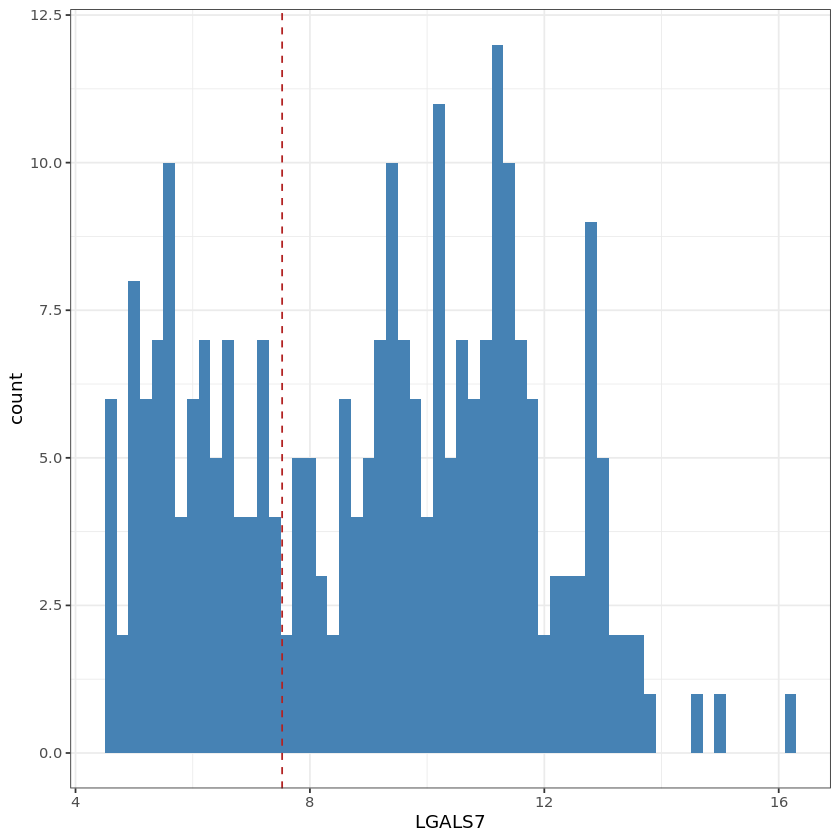

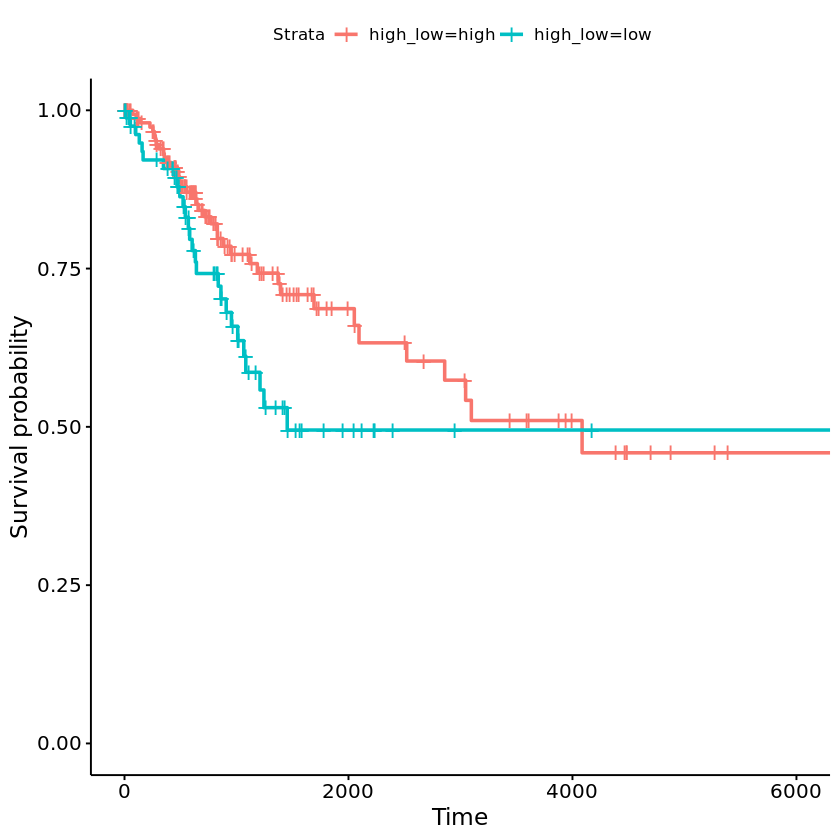

In [230]:
km_fit <- survfit(Surv(survival_time, vital_status) ~ high_low, type = "kaplan-meier", data = simp_survival_df)
survdiff(Surv(survival_time, vital_status) ~ high_low, data = simp_survival_df)

ggplot(data = simp_survival_df) +
    geom_histogram(aes_string(x = col_i), binwidth = 0.2, fill = "steelblue") +
    geom_vline(xintercept = center, color = "firebrick", linetype = 2) +
    theme_bw()

ggsurvplot(survfit(Surv(survival_time, vital_status) ~ high_low, data = simp_survival_df), data = simp_survival_df)
